In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Conv1D, GlobalMaxPool1D, concatenate, MaxPool1D
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import sys
sys.path.append('../../utils')
from preprocess import Preprocess
sys.path.append('../../config')
import matplotlib.pyplot as plt
from GlobalParams import MAX_SEQ_LEN

In [2]:
train_file = "total_train_data.csv"
data = pd.read_csv(train_file, delimiter=',')
# 데이터 구조 : 컬럼 2개(query, intent)
# query : 발화 내용
# intent : 발화 내용에 대한 label, 0~인사, 1~욕설, 2~주문, 3~예약, 4~기타
queries = data['query'].tolist()
intents = data['intent'].tolist()

In [3]:
# 전처리 객체
p = Preprocess(word2index_dic='../../train_tools/dict/chatbot_dict.bin',
               userdic='../../utils/user_dic.tsv')
# 단어 시퀀스 생성
sequences = []
for sentence in queries:
    pos = p.pos(sentence)
    keywords = p.pos(sentence)
    seq = p.get_wordidx_sequence(keywords)
    sequences.append(seq)

In [4]:
# 단어 시퀀스 벡터 생성
padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

# train, validation, test set 생성
dataset = tf.data.Dataset.from_tensor_slices((padded_seqs, intents))
dataset = dataset.shuffle(len(queries))

train_size = int(len(padded_seqs) * 0.7)
val_size = int(len(padded_seqs) * 0.2)
test_size = int(len(padded_seqs) * 0.1)

train_dataset = dataset.take(train_size).batch(20)
val_dataset = dataset.skip(train_size).take(val_size).batch(20)
test_dataset = dataset.skip(train_size + val_size).take(test_size).batch(20)

In [5]:
# 하이퍼 파라미터 설정
dropout_prob = 0.3 # 0.5에서 수정
EMB_SIZE = 128
EPOCH = 50
VOCAB_SIZE = len(p.word_index) + 1

In [6]:
# CNN 모델 정의 / conv층 추가, maxpool 층 추가, dropout 층 주석 처리 (210603)
input_layer = Input(shape=(MAX_SEQ_LEN,))
embedding_layer = Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_SEQ_LEN)(input_layer)
#dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)
# 3-gram / conv 층 추가
#conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
conv1 = Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu)(embedding_layer)
pool1 = MaxPool1D(padding='same')(conv1)
conv1_1 = Conv1D(filters=256, kernel_size=3, padding='same', activation=tf.nn.relu)(conv1)
pool1_1 = MaxPool1D(padding='same')(conv1_1)
conv1_2 = Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu)(pool1_1)
pool1_2 = MaxPool1D(padding='same')(conv1_2)
GMpool1 = GlobalMaxPool1D()(conv1_2)
# 4-gram / conv 층 추가
conv2 = Conv1D(filters=128, kernel_size=4, padding='same', activation=tf.nn.relu)(embedding_layer)
pool2 = MaxPool1D(padding='same')(conv2)
conv2_1 = Conv1D(filters=256, kernel_size=4, padding='same', activation=tf.nn.relu)(conv2)
pool2_1 = MaxPool1D(padding='same')(conv2_1)
conv2_2 = Conv1D(filters=128, kernel_size=4, padding='same', activation=tf.nn.relu)(conv2_1)
pool2_2 = MaxPool1D(padding='same')(conv2_2)
GMpool2 = GlobalMaxPool1D()(conv2_2)
# 5-gram / conv 층 추가
conv3 = Conv1D(filters=128, kernel_size=5, padding='same', activation=tf.nn.relu)(embedding_layer)
pool3 = MaxPool1D(padding='same')(conv3)
conv3_1 = Conv1D(filters=256, kernel_size=5, padding='same', activation=tf.nn.relu)(conv3)
pool3_1 = MaxPool1D(padding='same')(conv3_1)
conv3_2 = Conv1D(filters=128, kernel_size=5, padding='same', activation=tf.nn.relu)(conv3_1)
pool3_2 = MaxPool1D(padding='same')(conv3_2)
GMpool3= GlobalMaxPool1D()(conv3_2)

concat = concatenate([GMpool1, GMpool2, GMpool3])

hidden = Dense(128, activation=tf.nn.relu)(concat)
#dropout_hidden = Dropout(rate=dropout_prob)(hidden)
#logits = Dense(5, name='logits')(dropout_hidden)
logits = Dense(5, name='logits')(hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

In [7]:
'''
# CNN 모델 정의
input_layer = Input(shape=(MAX_SEQ_LEN,))
embedding_layer = Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_SEQ_LEN)(input_layer)
#dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

# 3-gram / conv 층 추가
#conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
conv1 = Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu)(embedding_layer)
pool1 = MaxPool1D(padding='same')(conv1)
conv1_1 = Conv1D(filters=256, kernel_size=3, padding='same', activation=tf.nn.relu)(pool1)
pool2 = MaxPool1D(padding='same')(conv1_1)
conv1_2 = Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu)(pool2)
pool3 = GlobalMaxPool1D()(conv1_2)

hidden = Dense(128, activation=tf.nn.relu)(pool3)
#dropout_hidden = Dropout(rate=dropout_prob)(hidden)
#logits = Dense(5, name='logits')(dropout_hidden)
logits = Dense(5, name='logits')(hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)
'''

"\n# CNN 모델 정의\ninput_layer = Input(shape=(MAX_SEQ_LEN,))\nembedding_layer = Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_SEQ_LEN)(input_layer)\n#dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)\n\n# 3-gram / conv 층 추가\n#conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)\nconv1 = Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu)(embedding_layer)\npool1 = MaxPool1D(padding='same')(conv1)\nconv1_1 = Conv1D(filters=256, kernel_size=3, padding='same', activation=tf.nn.relu)(pool1)\npool2 = MaxPool1D(padding='same')(conv1_1)\nconv1_2 = Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu)(pool2)\npool3 = GlobalMaxPool1D()(conv1_2)\n\nhidden = Dense(128, activation=tf.nn.relu)(pool3)\n#dropout_hidden = Dropout(rate=dropout_prob)(hidden)\n#logits = Dense(5, name='logits')(dropout_hidden)\nlogits = Dense(5, name='logits')(hidden)\npredictions = Dense(5, activation=tf.nn.softmax)(logits)\n"

In [8]:
# 모델 생성 / 모델 구조 변화 후 model_1 저장 ~ 목표 : val_acc 정확도 70퍼까지 올리기
model = Model(inputs=input_layer, outputs=predictions)
model.summary()
checkpoint = ModelCheckpoint('./intent_classification_best_model_1.h5', verbose = 1, monitor = 'val_loss', save_best_only = True)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.000001),
               loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=val_dataset,
                    epochs=EPOCH, verbose=1,callbacks=checkpoint)

loss, acc = model.evaluate(test_dataset, verbose=1)
print("ACC : %f"%(acc*100))
print("LOSS : %f"%loss)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 128)      2272128     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 15, 128)      49280       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 15, 256)      98560       conv1d[0][0]                     
_______________________________________________________________________________________

Text(0.5, 1.0, 'loss')

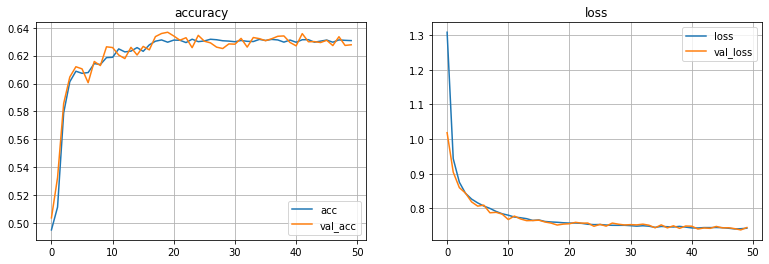

In [9]:
# Accuracy/validation plots
h = history.history
fig = plt.figure(figsize = (13, 4))

plt.subplot(121)
plt.plot(h['accuracy'], label = 'acc')
plt.plot(h['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

In [10]:
y_pred = model.predict(test_dataset)
y_pred_list = np.argmax(y_pred, axis=1)
y_pred_list

array([2, 3, 3, ..., 2, 3, 3])

In [11]:
len(y_pred_list)

10565

In [12]:
y_true_list = []
for _ ,datas in test_dataset.as_numpy_iterator():
    for data in datas:
        y_true_list.append(data)
print(len(y_true_list))

10565


<AxesSubplot:>

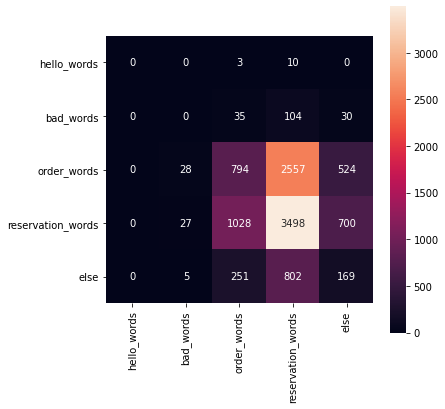

In [13]:
# confusion matrix
category = ['hello_words', 'bad_words', 'order_words', 'reservation_words', 'else']
confusion = confusion_matrix(y_true_list, y_pred_list)
fig = plt.figure(figsize = (6, 6))
sns.heatmap(confusion, annot = True, fmt = 'd', xticklabels = category, yticklabels = category, square = True)

In [14]:
# 교재 제공 모델 정확도 테스트